# Music machine learning - Adversarial learning

### Author: Philippe Esling (esling@ircam.fr)

Generative adversarial networks (GANs) are neural networks that generate material, such as images, music, speech, or text, that is similar to what humans produce.

In this course we will cover
1. The global principle of [adversarial learning](#adversarial)
2. How to train your own GAN on a [toy dataset](#toy)
3. A practical example on [MNIST](#mnist) using PyTorch

<a id="adversarial"></a>
## Adversarial learning

This is the code used in first example of the article [Generative Adversarial Networks: Build Your First Models](https://realpython.com/generative-adversarial-networks/) on Real Python.

In [1]:
import torch
from torch import nn
import math
import matplotlib.pyplot as plt
from helper_plot import hdr_plot_style
hdr_plot_style()

Generative adversarial networks (GANs) are machine learning systems that can learn to mimic a given distribution of data. GANs consist of two neural networks, one trained to *generate* data and the other trained to *discriminate* fake data from real data (hence the “adversarial” nature of the model).

GANs require to define two neural networks, one called the *generator* and the other called the *discriminator*. The role of the generator is to estimate the probability distribution of the real samples in order to provide generated samples resembling real data. The discriminator, in turn, is trained to estimate the probability that a given sample came from the real data rather than being provided by the generator.

These two networks define a *zero-sum game* as they are trained to compete with each other: the generator tries to get better at fooling the discriminator, while the discriminator tries to get better at identifying generated samples.

## Training GANs on a toy dataset

To understand how GAN training works, consider a toy example with a dataset composed of two-dimensional samples $(x_{1}, x_{2})$, with $x_{1}$ in the interval from $0$ to $2\pi$ and $x_{2} = sin(x_{1})$, as illustrated in the following 

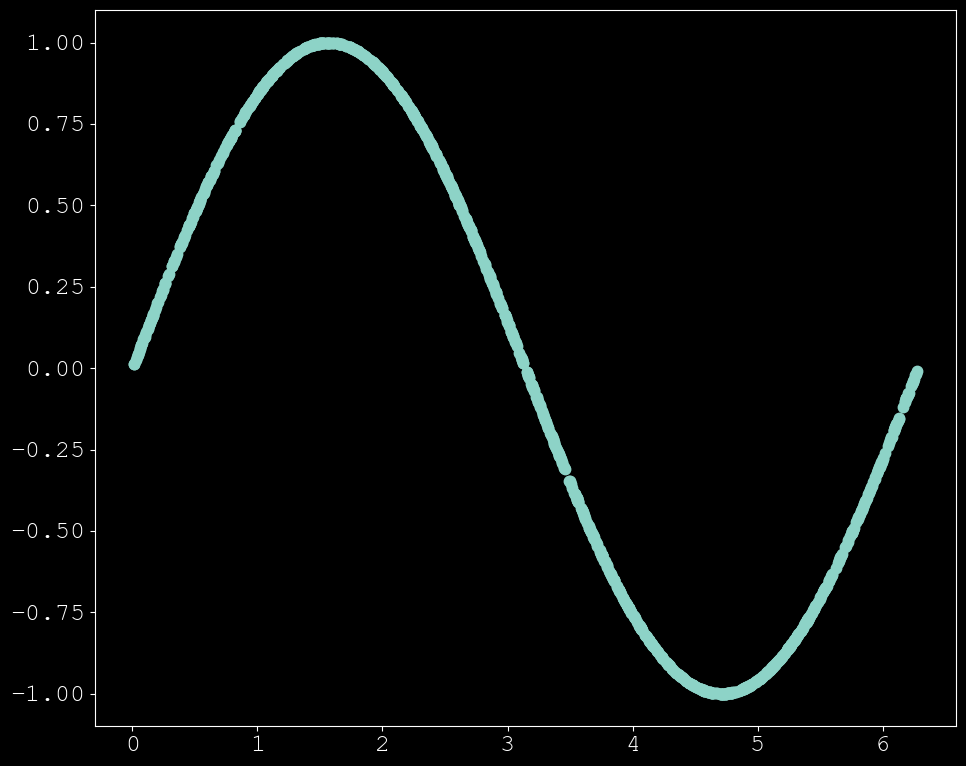

In [2]:
train_data_length = 1024
train_data = torch.zeros((train_data_length,2))
train_data[:,0] = 2*math.pi*torch.rand(train_data_length)
train_data[:,1] = torch.sin(train_data[:,0])

train_labels = torch.zeros(train_data_length)
trainset = [(train_data[i], train_labels[i]) for i in range(train_data_length)]

plt.figure(figsize=(10,8))
plt.plot(train_data[:, 0], train_data[:, 1], '.')
plt.tight_layout()

As usual, we need to define a `DataLoader` that will provide us with the training data in different batches.

In [3]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)

First, we define the generator, which is fed with random data from a latent space. Its role is to generate data resembling the real samples. In this example, you have a two-dimensional latent space, so that the generator is fed with random $(z_{1}, z_{2})$ pairs and is required to transform them so that they resemble the real samples.

We can define any type of network in the generator, given that it has sufficient complexity to generate the underlying type of data.

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [5]:
generator = Generator()

In turn, the discriminator is fed with either real samples from the training dataset or generated samples provided by the generator. Its role will be to estimate the probability that the input belongs to the real dataset or is a generated one. The training is performed so that the discriminator outputs 1 when it is fed a real sample and 0 when it is fed a generated sample. Again, we can choose any architecture of our liking for this network.

In [6]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        output = self.model(x)
        return output

In [7]:
discriminator = Discriminator()

We can now define our training hyper-parameters that will condition the learning procedure.

In [8]:
lr = 0.001
num_epochs = 500
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

The training procedure is defined as follows

In [9]:
loss_d = torch.zeros(int(num_epochs / 10))
loss_g = torch.zeros(int(num_epochs / 10))
for epoch in range(num_epochs):
    for n, (real_samples, _) in enumerate(train_loader):
        ##############################
        ## update the discriminator
        ##############################
        
        # zero the parameter gradients
        optimizer_discriminator.zero_grad()
        
        # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
        batch_size = real_samples.size(0)
        noise = torch.randn(batch_size, 2)
        fake_samples = generator(noise)
        
        # forward du discriminator
        disc_real_output = discriminator(real_samples)
        disc_fake_output = discriminator(fake_samples.detach()) # on detach fake_samples, car on n'a pas besoin d'avoir accès au gradient du generateur
        
        # calculate the loss for the discriminator
        loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
        
        # calculate the gradient for the discriminator
        loss_discriminator.backward()  
        
        # update the discriminator first
        optimizer_discriminator.step()
        
        ##############################
        ## update the Generator
        ##############################
        
        # zero the parameter gradients
        optimizer_generator.zero_grad()

        # forward du discriminator
        # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
        disc_fake_output = discriminator(fake_samples)
        
        # calculate the loss for the generator
        loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
        
        # calculate the gradient for the discriminator
        loss_generator.backward() 
        
        # update the generator
        optimizer_generator.step()
            
    # show loss
    if epoch % 10 == 0 and n == batch_size - 1:
        loss_d[int(epoch / 10)] = loss_discriminator
        loss_g[int(epoch / 10)] = loss_generator
        
        print("Epoch: {}".format(epoch))
        print("Generator loss: {:.4f},  Discriminator loss: {:.4f}".format(loss_generator, loss_discriminator))

Epoch: 0
Generator loss: 2.3977,  Discriminator loss: 0.2426
Epoch: 10
Generator loss: 0.7492,  Discriminator loss: 0.6947
Epoch: 20
Generator loss: 0.7841,  Discriminator loss: 0.6489
Epoch: 30
Generator loss: 0.7842,  Discriminator loss: 0.6396
Epoch: 40
Generator loss: 0.6744,  Discriminator loss: 0.6775
Epoch: 50
Generator loss: 0.6546,  Discriminator loss: 0.7028
Epoch: 60
Generator loss: 0.6837,  Discriminator loss: 0.7141
Epoch: 70
Generator loss: 0.6847,  Discriminator loss: 0.6759
Epoch: 80
Generator loss: 0.6376,  Discriminator loss: 0.7184
Epoch: 90
Generator loss: 0.6740,  Discriminator loss: 0.6896
Epoch: 100
Generator loss: 0.7289,  Discriminator loss: 0.6912
Epoch: 110
Generator loss: 1.4848,  Discriminator loss: 0.5532
Epoch: 120
Generator loss: 1.2395,  Discriminator loss: 0.6470
Epoch: 130
Generator loss: 0.7925,  Discriminator loss: 0.7785
Epoch: 140
Generator loss: 0.6928,  Discriminator loss: 0.6577
Epoch: 150
Generator loss: 0.9593,  Discriminator loss: 0.6352
Epo

If we look at the evolution of different losses, we can clearly see the competing nature of both networks

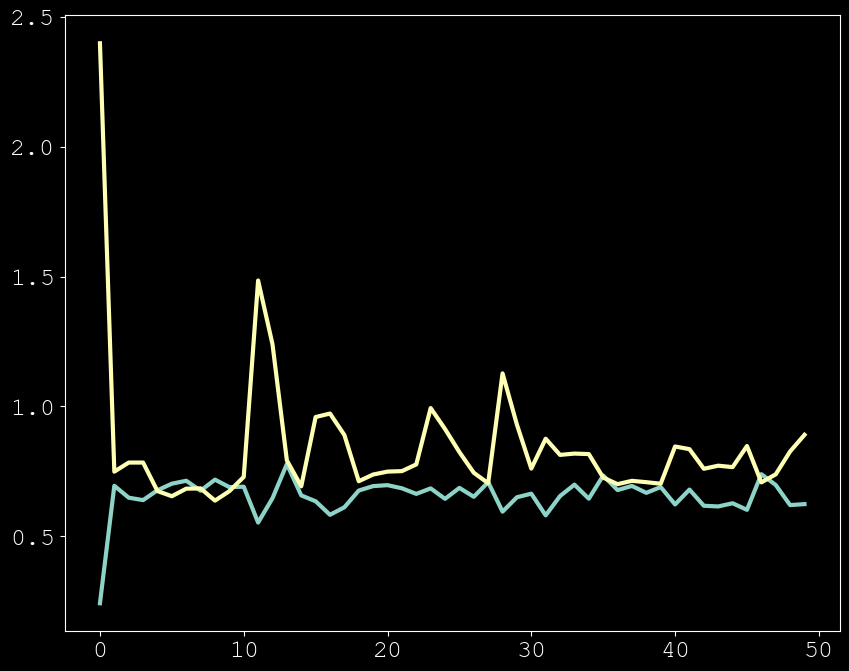

In [10]:
plt.figure(figsize=(10,8))
plt.plot(loss_d.detach())
plt.plot(loss_g.detach())

Now, we can visualize the samples that can be generated by drawing some random latent positions.

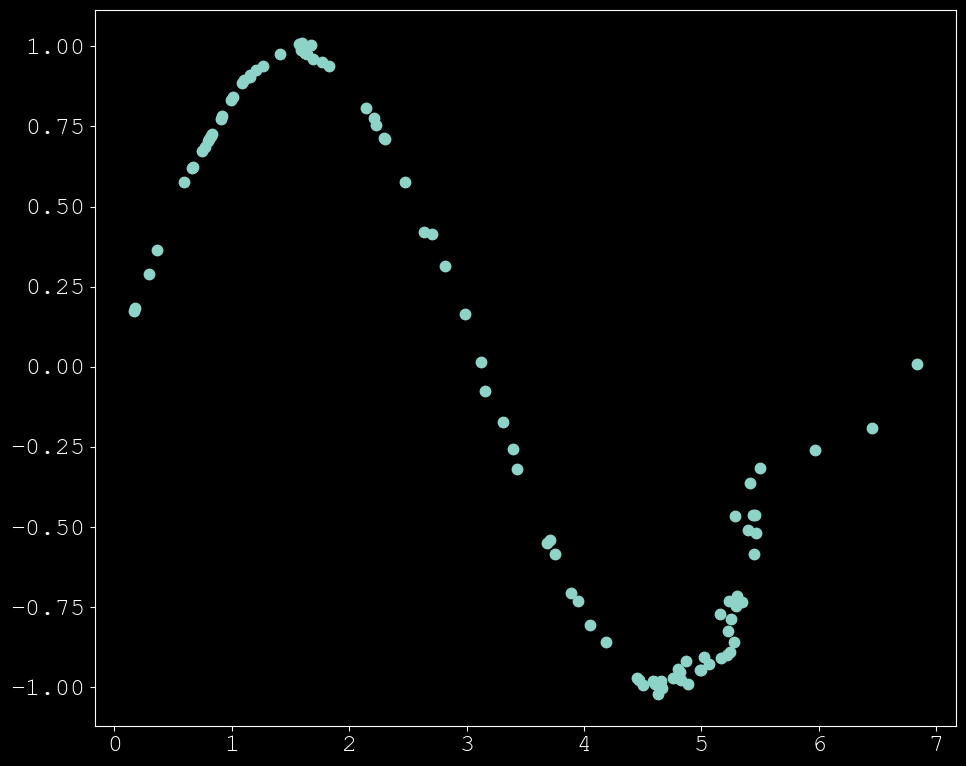

In [11]:
latent_space_samples = torch.randn(100, 2)
generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.detach()

plt.figure(figsize=(10,8))
plt.plot(generated_samples[:,0], generated_samples[:,1], '.')
plt.tight_layout()

As we can see, the randomly generated points closely follow the original distribution.

## Handwritten digits generator with GAN

Generative adversarial networks can also generate high-dimensional samples such as images. In this example, we are going to define a GAN to generate images of handwritten digits. For that, we will train the models using the infamous MNIST dataset. 

Again, we are going to make use of `torch` and `torchvision` . Notably, we will use `transforms` to obtain the training data and perform image conversions.

In [86]:
import torch
from torch import nn, optim
import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os

Since this example uses images in the training set, the models need to be more complex, with a larger number of parameters. This makes the training process slower, taking about two minutes per epoch when running on CPU. To reduce the training time, you can use a GPU to train the model if you have one available. The following piece of code allows to automatically select the best device available on your system.

In [87]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

### Preparing the training data

The MNIST dataset consists of 28 × 28 pixel grayscale images of handwritten digits from 0 to 9. To use them with PyTorch, we need to convert them to Tensors. Also, in order to ensure adequate learning, it is always best to normalize the data. This is were we make use of `torchvision.transforms` in order to perfom thesse automatically while loading the data.

In [88]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

Now, as usual, we can load both the *training* and *testing* data with the datasets objects

In [89]:
batch_size = 32

# Load the training set
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a batched data loader
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)

Here we plot some examples of the train set, to better understand the underlying data that we are working with.

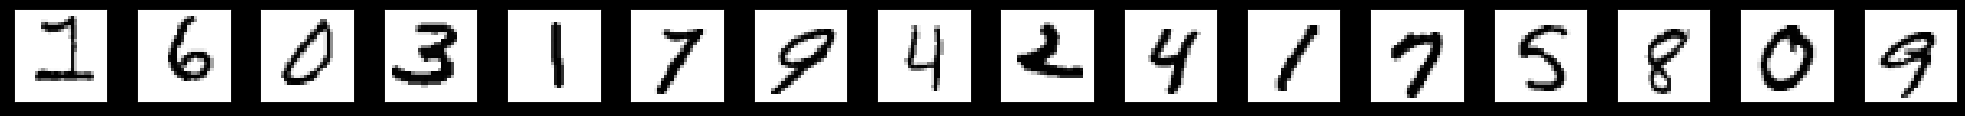

In [90]:
fig = plt.figure(figsize=(20,5))
real_samples, mnist_labels = next(iter(train_loader))
for i in range(16):
    ax = plt.subplot(1, 16, i+1)
    plt.imshow(real_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()    

### Implementing the discriminator and generator

Here, we are going to first define our *discriminator*. In our case, we will use an MLP, that will be responsible for receiving the images and trying to find which images are fake. The model is defined as follows 

In [91]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(-1, 784)
        output = self.model(x)
        return output

To input the image coefficients into the MLP neural network, you vectorize them so that the neural network receives vectors with 784 coefficients. The vectorization occurs in the first line of `.forward()`, as the call to `x.view()` converts the shape of the input tensor. In this case, the original shape of the input x is 32 × 1 × 28 × 28, where 32 is the batch size you’ve set up. After the conversion, the shape of x becomes 32 × 784, with each line representing the coefficients of an image of the training set.

To run the discriminator model using the GPU, you have to instantiate it and send it to the GPU with .to(). To use a GPU when there’s one available, you can send the model to the device object you created earlier:

In [92]:
discriminator = Discriminator().to(device=device)

Since the generator is going to generate more complex data, it’s necessary to increase the dimensions of the input from the latent space. In this case, the generator is going to be fed a 100-dimensional input and will provide an output with 784 coefficients, which will be organized in a 28 × 28 tensor representing an image. Here is the complete generator model code:

In [93]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh() # Tanh utile car les images du dataset sont normalisées entre [-1 ; 1].
        )

    def forward(self, x):
        # x = x.view(x.size(0), 100)
        output = self.model(x)
        output = output.view(x.size(0), 1, 28, 28)
        return output

In [94]:
generator = Generator().to(device=device)

As usual, we define the training hyper-parameters that will condition our learning procedure.

In [95]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [96]:
latent_space_samples_plot = torch.randn((batch_size, 100)).to(device=device)

Epoch: 0 Loss D.: 0.4995707869529724
Epoch: 0 Loss G.: 0.609161376953125


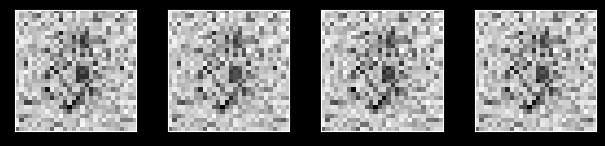

Epoch: 1 Loss D.: 0.36558520793914795
Epoch: 1 Loss G.: 3.7699356079101562


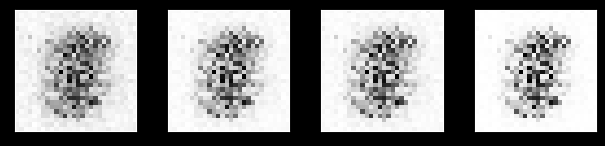

Epoch: 2 Loss D.: 0.18027785420417786
Epoch: 2 Loss G.: 4.322288990020752


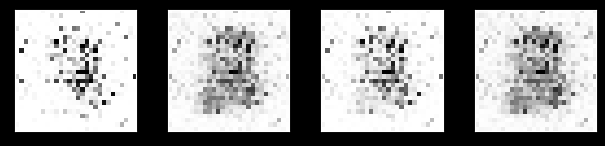

Epoch: 3 Loss D.: 0.2594277858734131
Epoch: 3 Loss G.: 3.4673523902893066


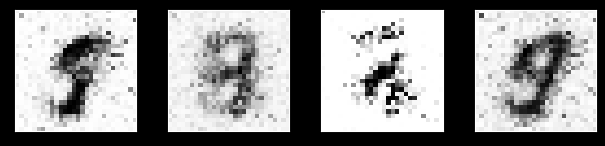

Epoch: 4 Loss D.: 0.17632652819156647
Epoch: 4 Loss G.: 3.0479941368103027


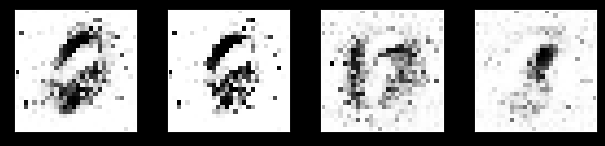

Epoch: 5 Loss D.: 0.3426239490509033
Epoch: 5 Loss G.: 2.098426103591919


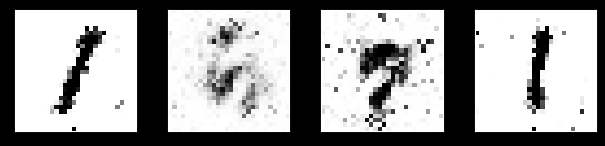

Epoch: 6 Loss D.: 0.2999116778373718
Epoch: 6 Loss G.: 1.6063498258590698


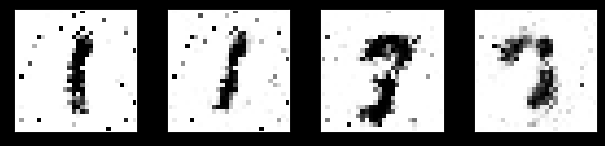

Epoch: 7 Loss D.: 0.4080290198326111
Epoch: 7 Loss G.: 2.067107677459717


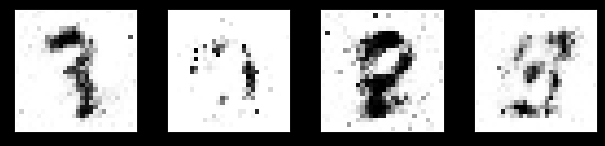

Epoch: 8 Loss D.: 0.39268073439598083
Epoch: 8 Loss G.: 1.8326128721237183


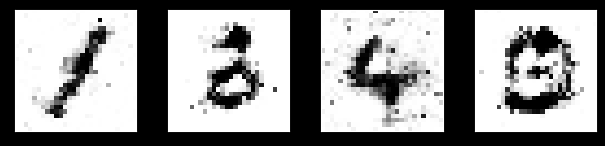

Epoch: 9 Loss D.: 0.31837910413742065
Epoch: 9 Loss G.: 1.549155592918396


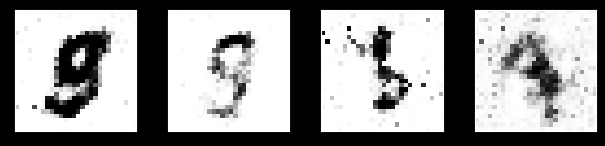

Epoch: 10 Loss D.: 0.5450862646102905
Epoch: 10 Loss G.: 1.509291410446167


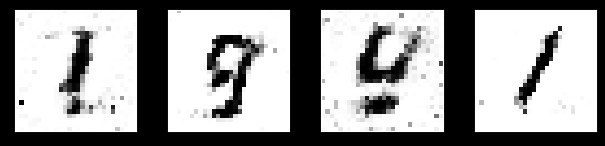

Epoch: 11 Loss D.: 0.40217646956443787
Epoch: 11 Loss G.: 1.7149163484573364


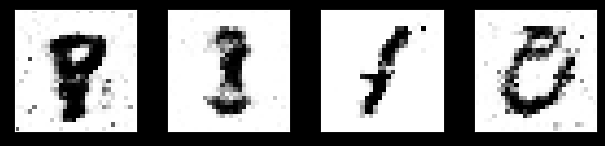

Epoch: 12 Loss D.: 0.5280154943466187
Epoch: 12 Loss G.: 1.1731258630752563


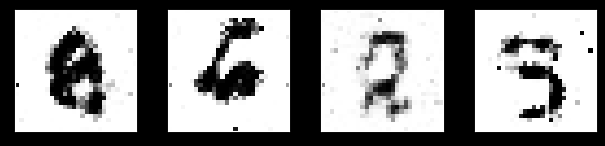

Epoch: 13 Loss D.: 0.3986137807369232
Epoch: 13 Loss G.: 1.7186839580535889


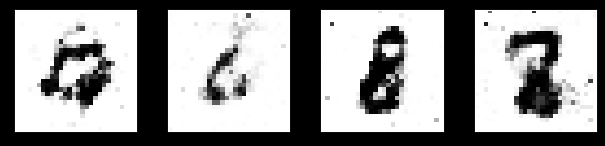

Epoch: 14 Loss D.: 0.5232458114624023
Epoch: 14 Loss G.: 1.3225946426391602


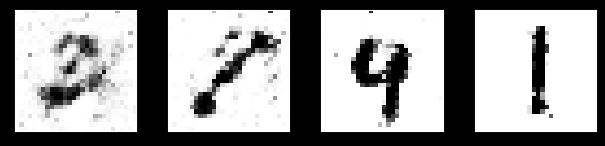

Epoch: 15 Loss D.: 0.4157581627368927
Epoch: 15 Loss G.: 1.6164566278457642


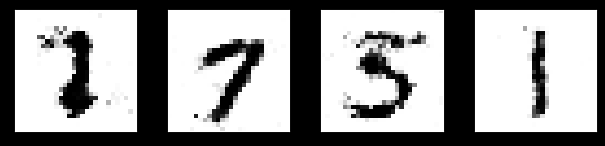

Epoch: 16 Loss D.: 0.41815251111984253
Epoch: 16 Loss G.: 1.6591240167617798


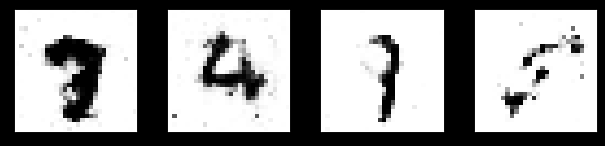

Epoch: 17 Loss D.: 0.5653445720672607
Epoch: 17 Loss G.: 1.5261967182159424


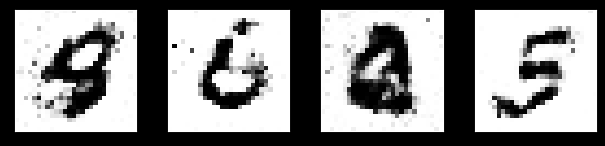

Epoch: 18 Loss D.: 0.6339151859283447
Epoch: 18 Loss G.: 1.2022650241851807


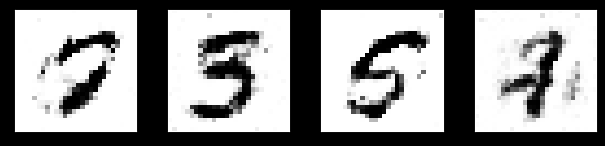

Epoch: 19 Loss D.: 0.42719119787216187
Epoch: 19 Loss G.: 1.428351640701294


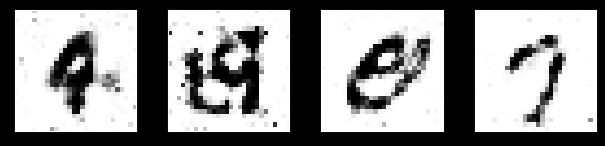

Epoch: 20 Loss D.: 0.5822775363922119
Epoch: 20 Loss G.: 1.0929949283599854


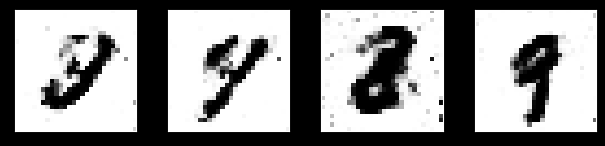

Epoch: 21 Loss D.: 0.6757394075393677
Epoch: 21 Loss G.: 1.1494003534317017


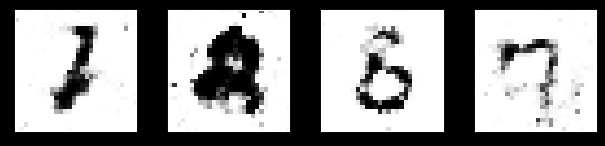

Epoch: 22 Loss D.: 0.5396281480789185
Epoch: 22 Loss G.: 1.0306756496429443


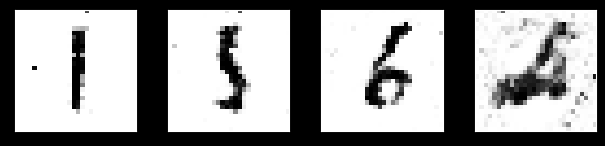

Epoch: 23 Loss D.: 0.5702552795410156
Epoch: 23 Loss G.: 1.129606008529663


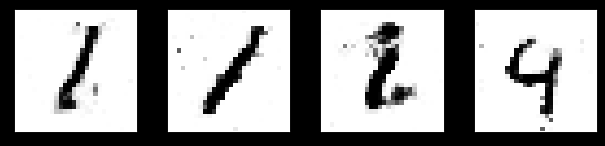

Epoch: 24 Loss D.: 0.5223206281661987
Epoch: 24 Loss G.: 1.2951544523239136


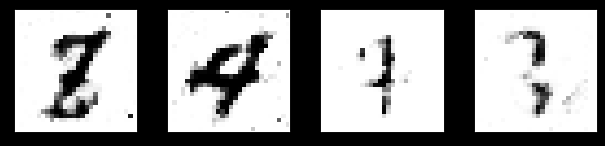

Epoch: 25 Loss D.: 0.7190197706222534
Epoch: 25 Loss G.: 1.2322964668273926


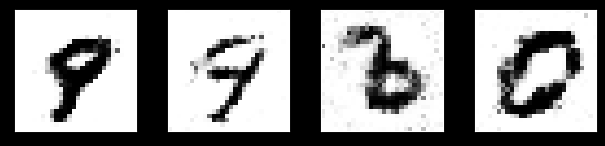

Epoch: 26 Loss D.: 0.5150949358940125
Epoch: 26 Loss G.: 1.3291913270950317


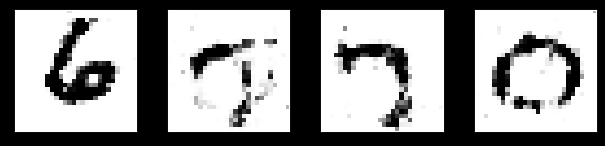

Epoch: 27 Loss D.: 0.7431907653808594
Epoch: 27 Loss G.: 0.9443238973617554


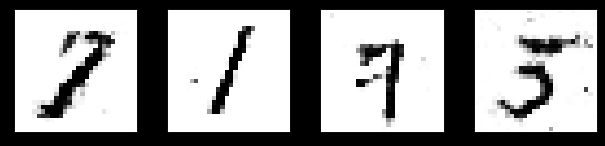

Epoch: 28 Loss D.: 0.4811645448207855
Epoch: 28 Loss G.: 0.9596981406211853


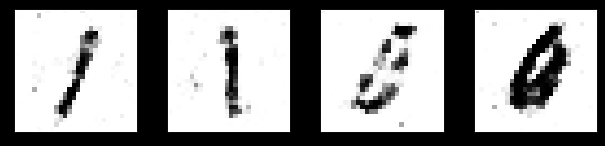

Epoch: 29 Loss D.: 0.6585352420806885
Epoch: 29 Loss G.: 1.1489168405532837


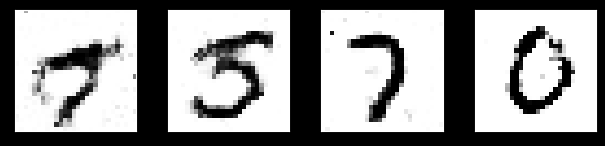

Epoch: 30 Loss D.: 0.4315384328365326
Epoch: 30 Loss G.: 1.103281855583191


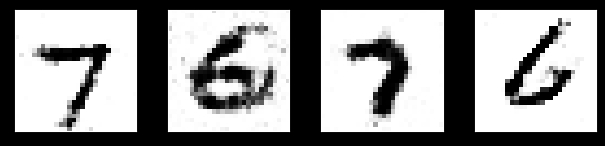

Epoch: 31 Loss D.: 0.583977460861206
Epoch: 31 Loss G.: 1.0841314792633057


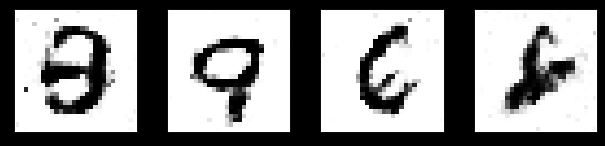

Epoch: 32 Loss D.: 0.5924558639526367
Epoch: 32 Loss G.: 1.1491243839263916


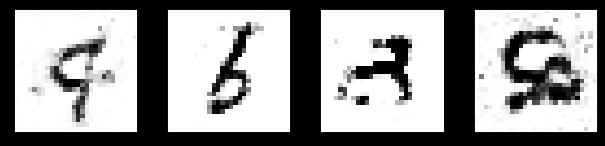

Epoch: 33 Loss D.: 0.5933221578598022
Epoch: 33 Loss G.: 1.0161302089691162


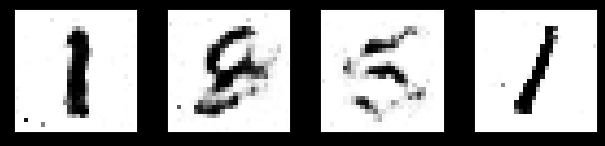

Epoch: 34 Loss D.: 0.6482089161872864
Epoch: 34 Loss G.: 1.0095770359039307


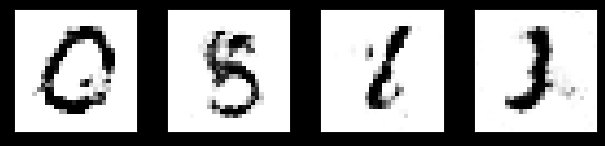

Epoch: 35 Loss D.: 0.655180811882019
Epoch: 35 Loss G.: 0.9739683866500854


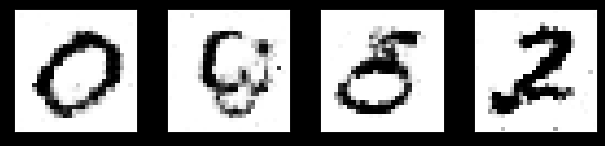

Epoch: 36 Loss D.: 0.6809147596359253
Epoch: 36 Loss G.: 0.961939811706543


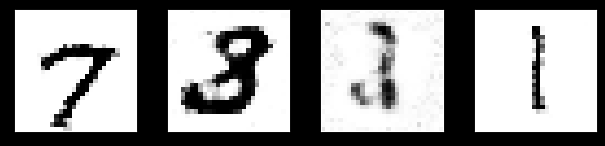

Epoch: 37 Loss D.: 0.6246531009674072
Epoch: 37 Loss G.: 0.9373122453689575


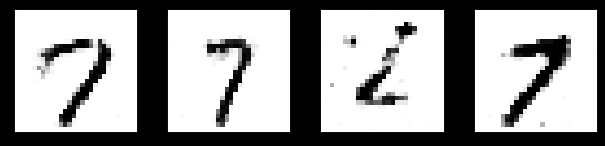

Epoch: 38 Loss D.: 0.5530524253845215
Epoch: 38 Loss G.: 1.0983662605285645


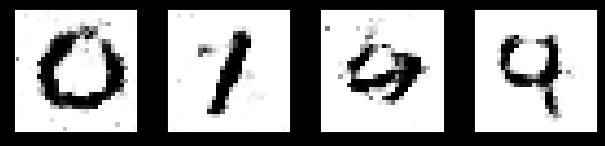

Epoch: 39 Loss D.: 0.5789209008216858
Epoch: 39 Loss G.: 0.9189453125


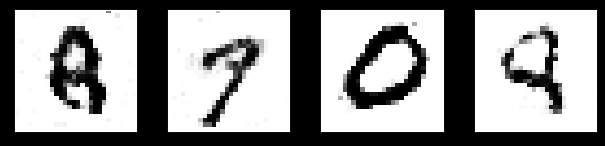

Epoch: 40 Loss D.: 0.5924520492553711
Epoch: 40 Loss G.: 0.9417070150375366


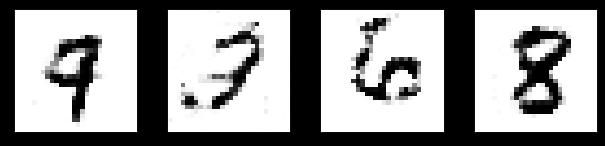

Epoch: 41 Loss D.: 0.5369303226470947
Epoch: 41 Loss G.: 1.1785328388214111


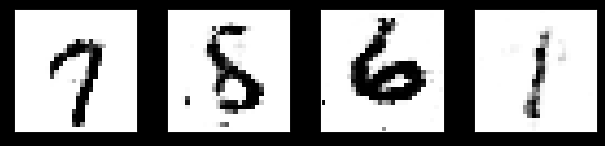

Epoch: 42 Loss D.: 0.5342799425125122
Epoch: 42 Loss G.: 1.1484434604644775


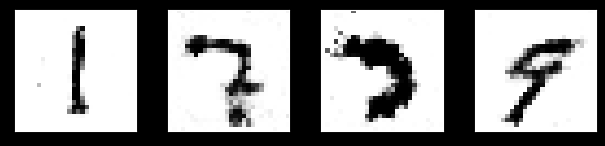

Epoch: 43 Loss D.: 0.604512095451355
Epoch: 43 Loss G.: 1.016816258430481


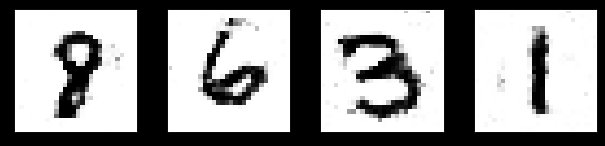

Epoch: 44 Loss D.: 0.6077576279640198
Epoch: 44 Loss G.: 0.9164934754371643


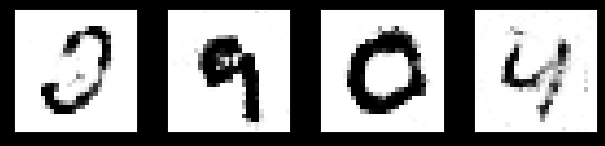

Epoch: 45 Loss D.: 0.6310502886772156
Epoch: 45 Loss G.: 0.9176626205444336


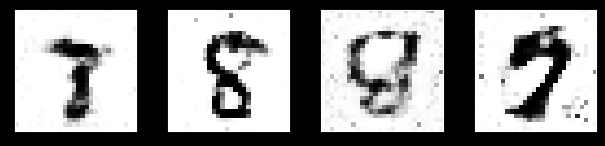

Epoch: 46 Loss D.: 0.5913938283920288
Epoch: 46 Loss G.: 0.9609386920928955


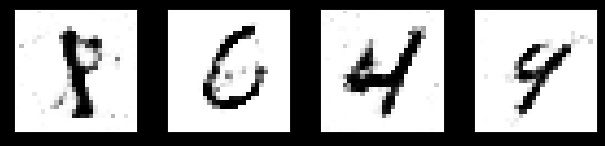

Epoch: 47 Loss D.: 0.5895231366157532
Epoch: 47 Loss G.: 1.0292950868606567


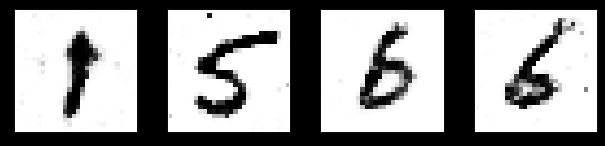

Epoch: 48 Loss D.: 0.59604811668396
Epoch: 48 Loss G.: 0.969123363494873


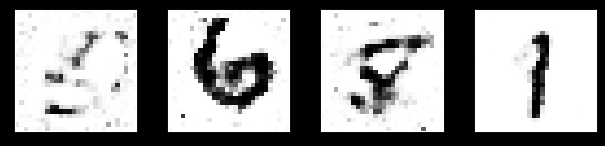

Epoch: 49 Loss D.: 0.6798608303070068
Epoch: 49 Loss G.: 0.9573911428451538


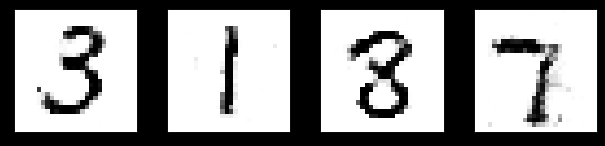

In [97]:
# Load trained NN when it exists, or train a new NN
if os.path.isfile('discriminator.pt') and os.path.isfile('generator.pt'):
    discriminator.load_state_dict(torch.load('./discriminator.pt'))
    generator.load_state_dict(torch.load('./generator.pt'))
else:
    for epoch in range(num_epochs):
        for n, (real_samples, mnist_labels) in enumerate(train_loader):
            ##############################
            ## update the discriminator
            ##############################
            
            # zero the parameter gradients
            optimizer_discriminator.zero_grad()
            
            # forward du generator, creation d'un batch de fake samples (noise, puis passage dans generateur)
            batch_size = real_samples.size(0)
            noise = torch.randn(batch_size, 100).to(device=device)
            fake_samples = generator(noise)
            
            # forward du discriminator
            disc_real_output = discriminator(real_samples)
            disc_fake_output = discriminator(fake_samples.detach()) # on detach fake_samples, car on n'a pas besoin d'avoir accès au gradient du generateur
            
            # calculate the loss for the discriminator
            loss_discriminator = 1/2 * (loss_function(disc_real_output, torch.ones_like(disc_real_output)) + loss_function(disc_fake_output, torch.zeros_like(disc_fake_output)))
            
            # calculate the gradient for the discriminator
            loss_discriminator.backward()  
            
            # update the discriminator first
            optimizer_discriminator.step()
            
            ##############################
            ## update the Generator
            ##############################
            
            # zero the parameter gradients
            optimizer_generator.zero_grad()

            # forward du discriminator
            # on ne detach pas fake_samples, car on veut garder les gradient pour pouvoir entrainer le generateur
            disc_fake_output = discriminator(fake_samples)
            
            # calculate the loss for the generator
            loss_generator = loss_function(disc_fake_output, torch.ones_like(disc_fake_output),)
            
            # calculate the gradient for the discriminator
            loss_generator.backward() 
            
            # update the generator
            optimizer_generator.step()

            # Show loss
            if n == batch_size - 1:
                print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
                print(f"Epoch: {epoch} Loss G.: {loss_generator}")
                
                latent_space_samples = torch.randn(batch_size, 100).to(device=device)

                generated_samples = generator(latent_space_samples)
                generated_samples = generated_samples.cpu().detach()

                plt.figure()
                for i in range(4):
                    ax = plt.subplot(1, 4, i+1)
                    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
                    plt.xticks([])
                    plt.yticks([])
                plt.tight_layout()
                plt.show()

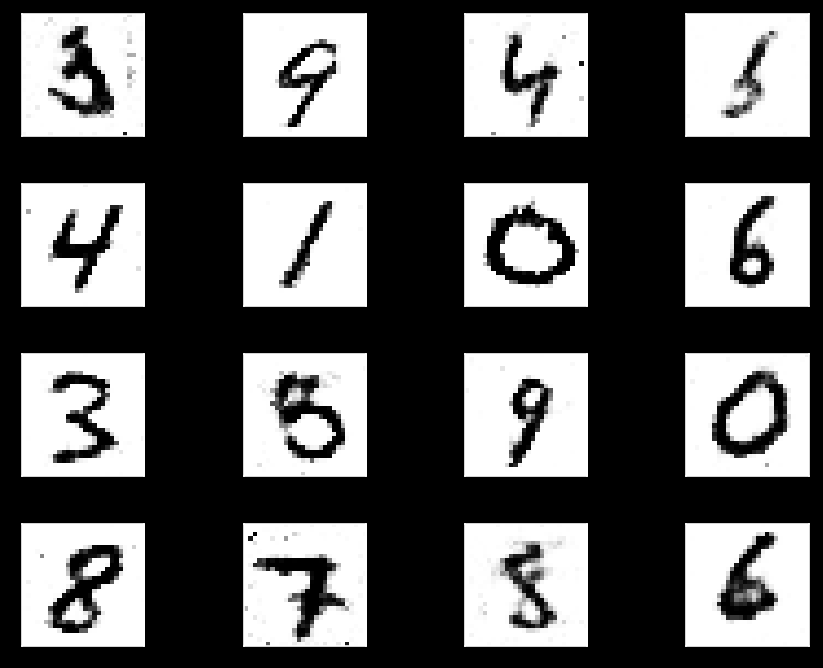

In [98]:
latent_space_samples = torch.randn(batch_size, 100).to(device=device)

generated_samples = generator(latent_space_samples)
generated_samples = generated_samples.cpu().detach()

plt.figure(dpi=150)
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(generated_samples[i].reshape(28, 28), cmap='gray_r')
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()

In [99]:
# Save trained NN parameters
torch.save(generator.state_dict(), 'generator.pt')
torch.save(discriminator.state_dict(), 'discriminator.pt')